In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In /home/hep/mhh18/.config/matplotlib/stylelib/cms-img.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms-img.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms-img.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hep/mhh18/.config/matplotlib/stylelib/cms.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.

In [3]:
sys.path.insert(0, '..') #add paernet directory to the list in which packages are searched

In [4]:
from funcs import getParMtxPerBundle, getModulesPerBundle

Welcome to JupyROOT 6.22/06


In [5]:
with open('../input/allocation/allocation_20200729_1.txt') as f:
    lines = [line.rstrip('\n') for line in f]
f.close()

In [6]:
bundles = getModulesPerBundle(lines)

In [7]:
parMtxEM_PerBundle, parMtxHad_PerBundle = getParMtxPerBundle(bundles, '../output/tower_module_mapping_array/', 'param_mtx_em.pkl', 'param_mtx_had.pkl')

In [8]:
indicesEM = [idx[3:] for idx in parMtxEM_PerBundle[0].index]
indicesHad = [idx[4:] for idx in parMtxHad_PerBundle[0].index]

In [9]:
indices = indicesEM + list(set(indicesHad) - set(indicesEM))

In [147]:
df = pd.DataFrame({'EM':np.zeros(len(indices)), 'Had':np.zeros(len(indices))}, index = indices).astype(int)
for bundle in parMtxEM_PerBundle:
    towers = [tower[3:] for tower in parMtxEM_PerBundle[bundle][(parMtxEM_PerBundle[bundle] != 0).any(axis=1)].index]
    df.loc[df.index.isin(towers), 'EM'] += 1
for bundle in parMtxHad_PerBundle:
    towers = [tower[4:] for tower in parMtxHad_PerBundle[bundle][(parMtxHad_PerBundle[bundle] != 0).any(axis=1)].index]
    df.loc[df.index.isin(towers), 'Had'] += 1

In [148]:
def plotHist(data):
    data=data[data!=0]
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    title = 'CE-E' if data.name=='EM' else 'CE-H'
    textMaxPosition = 70 if data.name=='EM' else 57
    mean = 'mean = ' + str(round(data.mean(),2))
    maximum = 'max = ' + str(data.max())
    tot_towers = 'num. of towers = ' + str(len(data))
    binwidth = 1
    bins=np.arange(1, max(data) + 2*binwidth, binwidth)
    plt.hist(data, bins, ec='black')
    plt.xticks(bins[::2])
    plt.text(1, textMaxPosition, tot_towers, fontdict=font)
    plt.text(1, textMaxPosition-7, mean, fontdict=font)
    plt.text(1, textMaxPosition-14, maximum, fontdict=font)
    plt.xlabel('number of Stage 1 FPGAs sending tower')
    plt.ylabel('number of towers')
    plt.title(title)
    plt.savefig('numOfStage1FPGAsSendingTower_'+data.name+'.pdf')

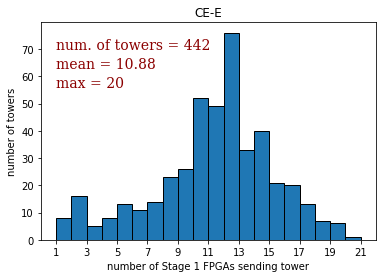

In [149]:
data = df['EM']
plotHist(data)

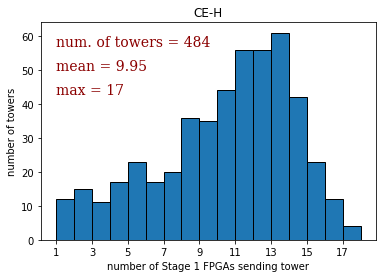

In [150]:
data = df['Had']
plotHist(data)